In [1]:
#importing necessary packages
import pandas as pd
import matplotlib.pyplot as plt

# Loading Datasets

In [2]:
data_movie = pd.read_csv("movie.csv") #Datset eccontaining movie names
data_rating = pd.read_csv("rating.csv") #Dataset with rating of the movies given by each user

# Data Modelling

In [3]:
data_movie.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
data_movie.shape

(27278, 3)

In [5]:
#n collaborative filtering we dont ned the content of the item.
data_movie.drop(['genres'],axis=1,inplace=True)

In [6]:
data_rating.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [7]:
#droping timesttamp column
data_rating = data_rating.loc[:,["userId","movieId","rating"]]
data_rating.head()

,userId,movieId,rating
0,1,2.0,3.5
1,1,29.0,3.5
2,1,32.0,3.5
3,1,47.0,3.5
4,1,50.0,3.5


We will merge the movie and rating dataset


In [8]:
df = pd.merge(data_movie,data_rating)
df.head()

,movieId,title,userId,rating
0,1,Toy Story (1995),3,4.0
1,1,Toy Story (1995),6,5.0
2,1,Toy Story (1995),8,4.0
3,1,Toy Story (1995),10,4.0
4,1,Toy Story (1995),11,4.5


In [9]:
df.describe()

,movieId,userId,rating
count,97832.000000,97832.000000,97832.000000
mean,8543.652261,355.488818,3.509276
std,19001.182097,192.621423,1.061532
min,1.000000,1.000000,0.500000
25%,858.000000,189.000000,3.000000
50%,2115.000000,367.000000,3.500000
75%,4447.000000,520.000000,4.000000
max,128488.000000,685.000000,5.000000


# Analysing the data

The mean rating of top 20 rated movies:

In [10]:
df.groupby("title").mean()['rating'].sort_values(ascending=False).head(20)

title
Foul Play (1978)                                                              5.0
Phantom of Liberty, The (Fantôme de la liberté, Le) (1974)                    5.0
Dog's Life, A (1918)                                                          5.0
Poolhall Junkies (2002)                                                       5.0
Predestination (2014)                                                         5.0
Prick Up Your Ears (1987)                                                     5.0
His Secret Life (a.k.a. Ignorant Fairies, The) (Fate ignoranti, Le) (2001)    5.0
Public Access (1993)                                                          5.0
White Rose, The (Weiße Rose, Die) (1982)                                      5.0
Rabid (1977)                                                                  5.0
Inspector Palmu's Error (Komisario Palmun erehdys) (1960)                     5.0
Diary of a Chambermaid (Journal d'une femme de chambre, Le) (1964)            5.0
Ratcatcher

The movies which have been rated by most number of users:

In [11]:
df.groupby("title").count()["rating"].sort_values(ascending=False).head(20)

title
Pulp Fiction (1994)                                      342
Forrest Gump (1994)                                      330
Shawshank Redemption, The (1994)                         299
Jurassic Park (1993)                                     296
Silence of the Lambs, The (1991)                         288
Star Wars: Episode IV - A New Hope (1977)                256
Braveheart (1995)                                        254
Terminator 2: Judgment Day (1991)                        250
Matrix, The (1999)                                       247
Schindler's List (1993)                                  241
Toy Story (1995)                                         233
American Beauty (1999)                                   232
Fugitive, The (1993)                                     230
Independence Day (a.k.a. ID4) (1996)                     230
Apollo 13 (1995)                                         227
Star Wars: Episode VI - Return of the Jedi (1983)        225
Star Wars: Episode

Checking the most common rating given by users:

<function matplotlib.pyplot.show>

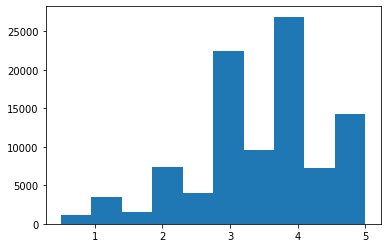

In [12]:
plt.hist(data_rating['rating'])
plt.show

Observation: 3-4 is the most common rating of the movies

# Creating an user-item table for Item Based Collaborative Fitering

In [13]:
pivot_table = df.pivot_table(index = ["userId"],columns = ["title"],values = "rating").fillna(0) # the null values are set as 0 for ease of calculation
pivot_table.head(5)

title,'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),(Untitled) (2009),*batteries not included (1987),...And Justice for All (1979),1-900 (06) (1994),10 (1979),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Rifles (1969),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),11:14 (2003),"11th Hour, The (2007)",12 (2007),12 Angry Men (1957),12 Rounds (2009),12 Years a Slave (2013),127 Hours (2010),12:01 (1993),13 Assassins (Jûsan-nin no shikaku) (2010),13 Ghosts (1960),13 Going on 30 (2004),13 Rue Madeleine (1947),13 Tzameti (2005),13Hrs (2010),"13th Warrior, The (1999)",14 Blades (Jin yi wei) (2010),1408 (2007),15 Minutes (2001),...,"Young Visiters, The (2003)",Young and Innocent (1937),"Young and Prodigious T.S. Spivet, The (L'extravagant voyage du jeune et prodigieux T.S. Spivet) (2013)","Young and the Damned, The (Olvidados, Los) (1950)",Young at Heart (a.k.a. Young@Heart) (2007),Youngblood (1986),Your Friends and Neighbors (1998),Your Highness (2011),"Yours, Mine and Ours (2005)",Youth in Revolt (2009),Yu-Gi-Oh! (2004),Z (1969),Zachariah (1971),Zack and Miri Make a Porno (2008),Zapped! (1982),Zathura (2005),Zazie dans le métro (1960),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Ziggy Stardust and the Spiders from Mars (1973),Zodiac (2007),Zombieland (2009),Zookeeper (2011),Zoolander (2001),"Zorro, the Gay Blade (1981)",Zulu (1964),Zus & Zo (2001),"\\""Great Performances\""\"" Cats (1998)""",eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
pivot_table.shape

(685, 8200)

# Recommending Movies

In [15]:
#The function returns top 5 movies with highest correlation
def recommend_movie(movie):
    movie_watched = pivot_table[movie]
    similarity_with_other_movies = pivot_table.corrwith(movie_watched,method='pearson')  
    similarity_with_other_movies = similarity_with_other_movies.sort_values(ascending=False)
    return similarity_with_other_movies.head(6)

In [16]:
recommend_movie('American President, The (1995)')

title
American President, The (1995)    1.000000
Dave (1993)                       0.505434
Sleepless in Seattle (1993)       0.498727
Ghost (1990)                      0.431900
Client, The (1994)                0.395921
While You Were Sleeping (1995)    0.392365
dtype: float64

In [17]:
recommend_movie('Sleepless in Seattle (1993)')

title
Sleepless in Seattle (1993)       1.000000
Pretty Woman (1990)               0.555908
Ghost (1990)                      0.534854
Mrs. Doubtfire (1993)             0.532611
Dave (1993)                       0.514941
American President, The (1995)    0.498727
dtype: float64

Observation: 'The American President' recommends movies like Sleepless in Seattle, dave and Ghost.
Dave,Ghost and The American President again appears in the recommendation of Sleepless in Seattle.

So the movie recommendation seems to work fine.

In [18]:
recommend_movie('Pulp Fiction (1994)')

title
Pulp Fiction (1994)                 1.000000
Usual Suspects, The (1995)          0.501555
Reservoir Dogs (1992)               0.478631
Silence of the Lambs, The (1991)    0.467498
Seven (a.k.a. Se7en) (1995)         0.466532
Taxi Driver (1976)                  0.398981
dtype: float64

observaion: Pulp Fiction being an action thriller , other action thriller movies like The silence of the Lambs, Seven and The usual suspects are some good fits.